In [5]:
from qiskit import *
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import pennylane as qml
import jax
import jax.numpy as jnp


In [6]:
import pennylane as qml
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)

In [7]:
def get_hamiltonian_n_site_terms(n, coeff, n_qubits):
    XX_coeff = coeff[0]
    YY_coeff = coeff[1]
    ZZ_coeff = coeff[2]
    Z_coeff = coeff[3]
    return (SparsePauliOp(("I" * n + "XX" + "I" * (n_qubits - 2 - n))) * XX_coeff + 
            SparsePauliOp(("I" * n + "YY" + "I" * (n_qubits - 2 - n))) * YY_coeff + 
            SparsePauliOp(("I" * n + "ZZ" + "I" * (n_qubits - 2 - n))) * ZZ_coeff + 
            SparsePauliOp(("I" * n + "Z" + "I" * (n_qubits - 1 - n))) * Z_coeff)
coeff = [0,1,2,3]
# get_hamiltonian_n_site_terms(1,coeff,4)

In [8]:
def get_heisenberg_hamiltonian(n_qubits, coeff=None):
    # Three qubits because for 2 we get H_O = 0
    assert n_qubits >= 3

    if coeff == None:
        coeff = [[1.0, 1.0, 1.0, 1.0] for i in range(n_qubits)]

    # Even terms of the Hamiltonian (summing over individual pair-wise elements)
    H_E = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits) 
               for i in range(0, n_qubits - 1, 2)))

    # Odd terms of the Hamiltonian (summing over individual pair-wise elements)
    H_O = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits) 
               for i in range(1, n_qubits - 1, 2)))

    # adding final Z term at the Nth site
    if (n_qubits % 2) == 0:
        H_E += SparsePauliOp(("I" * (n_qubits - 1) + "Z")) * coeff[n_qubits - 1][3]
    else:
        H_O += SparsePauliOp(("I" * (n_qubits - 1) + "Z")) * coeff[n_qubits - 1][3]

    return [H_E, H_O]

get_heisenberg_hamiltonian(6)

[SparsePauliOp(['XXIIII', 'YYIIII', 'ZZIIII', 'ZIIIII', 'IIXXII', 'IIYYII', 'IIZZII', 'IIZIII', 'IIIIXX', 'IIIIYY', 'IIIIZZ', 'IIIIZI', 'IIIIIZ'],
               coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
  1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]),
 SparsePauliOp(['IXXIII', 'IYYIII', 'IZZIII', 'IZIIII', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIZII'],
               coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])]

Convert Hamiltonain for Pennylane

In [9]:
from qiskit.quantum_info import SparsePauliOp

num_wires = 3
wires = list(range(num_wires))
np.random.seed(62213)

# Define the Hamiltonian
hamiltonian = get_heisenberg_hamiltonian(num_wires)[0] - get_heisenberg_hamiltonian(num_wires)[1]
# hamiltonian = SparsePauliOp.from_list([
#     ("IIZZ", 1), ("ZIZI", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
# ])

# Convert the SparsePauliOp to a matrix
H_matrix = hamiltonian.to_matrix()
H = qml.Hermitian(H_matrix, wires=wires)

# Compute the eigenvalues and eigenvectors of the Hamiltonian

E_min_noisy = min(qml.eigvals(H))

# eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
# eigenvalues



In [10]:

num_wires = 4  # Number of qubits
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))
dev = qml.device("default.qubit", wires=num_wires)

# Initialize parameters for different circuit repetitions
repetitions = [2,4,6,8,10]
param_shapes = [(rep, 2, 2, d) for rep in repetitions]
init_params_list = [np.random.randn(*shape) for shape in param_shapes] # give same initial parameters for each repetitions
init_params_list = [np.ones(shape) for shape in param_shapes] # give same initial parameters for each repetitions



# Define the quantum circuit function
def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [(loc * j + i + w) % num_wires for w in range(loc)]
                operation(params_op, wires_op)
    return qml.expval(H)

# Create QNodes for different circuit repetitions
qnodes = [qml.QNode(circuit, dev, interface="jax") for _ in repetitions]


print(qml.draw(qnodes[1])(init_params_list[1], qml.SpecialUnitary))

#qnodes[0](init_params_list[0], qml.SpecialUnitary)#(params,operation)


0: ─╭SpecialUnitary(M0)─────────────────────╭SpecialUnitary(M0)─╭SpecialUnitary(M0)
1: ─╰SpecialUnitary(M0)─╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)
2: ─╭SpecialUnitary(M0)─╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)
3: ─╰SpecialUnitary(M0)─────────────────────╰SpecialUnitary(M0)─╰SpecialUnitary(M0)

──────────────────────╭SpecialUnitary(M0)─╭SpecialUnitary(M0)────────────────────
──╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)─╭SpecialUnitary(M0)
──╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)─╰SpecialUnitary(M0)
──────────────────────╰SpecialUnitary(M0)─╰SpecialUnitary(M0)────────────────────

──╭SpecialUnitary(M0)─╭SpecialUnitary(M0)─────────────────────╭SpecialUnitary(M0)─┤ ╭<𝓗(M1)>
──│───────────────────╰SpecialUnitary(M0)─╭SpecialUnitary(M0)─│───────────────────┤ ├<𝓗(M1)>
──│───────────────────╭SpecialUnitary(M0)─╰SpecialUnitary(M0)─│───────────────────┤ ╰<𝓗(M1)>
──╰SpecialUnitary(M0)─╰SpecialUnitary(M0)──────────────

In [15]:
learning_rate = 5e-4
num_steps = 300
#grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)

# Define a function to run optimization for each circuit repetition
def optimize(i, operation): # i stands for repetition index
    grad_fn = jax.jit(jax.jacobian(qnodes[i]), static_argnums=1)
    energies = []
    params = init_params_list[i]
    #qnode
    for step in range(num_steps):
        cost = qnodes[i](params,operation)
        params = params - learning_rate * grad_fn(params, operation)
        energies.append(cost)
    energies.append(cost)
    return energies

c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: 

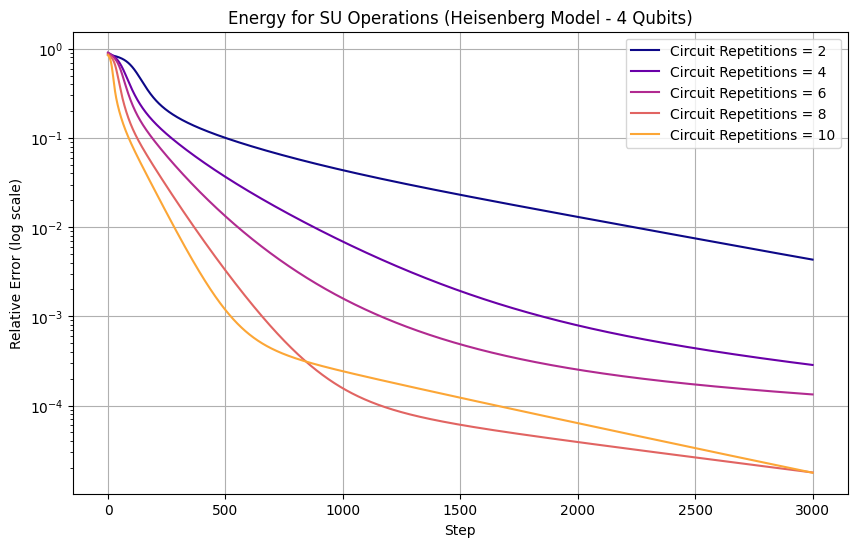

In [12]:
# Plot the relative errors for Special Unitary operations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i,rep in enumerate(repetitions):
    e = optimize(i,qml.SpecialUnitary)#qml.SpecialUnitary
    error = (e - E_min_noisy) / abs(E_min_noisy)

    color = plt.cm.plasma(i / len(repetitions))  # Get color from a colormap
    plt.plot(np.arange(num_steps+1), error, color=color, label=f"Circuit Repetitions = {rep}")  # Label each curve
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Energy for SU Operations (Heisenberg Model - 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Relative Error (log scale)")
plt.legend()
plt.grid(True)
plt.show()



KeyboardInterrupt: 

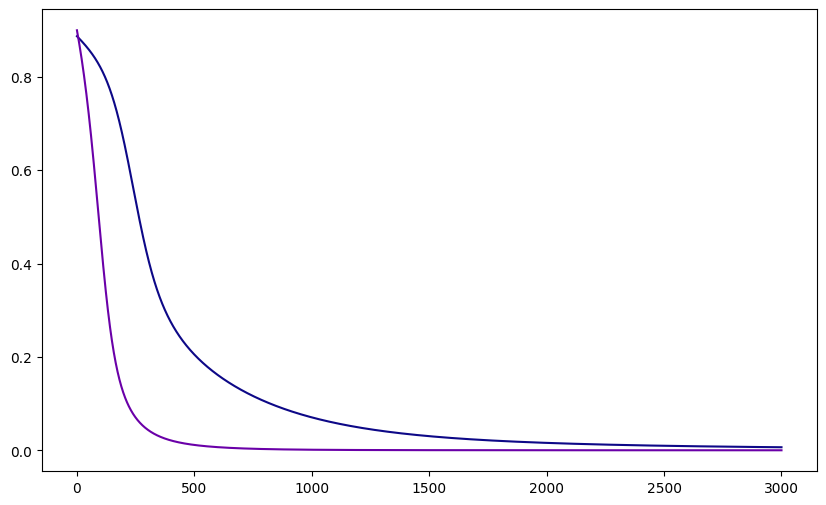

In [13]:
# Plot the relative errors for Special Unitary operations
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
for i,rep in enumerate(repetitions):
    e = optimize(i,two_qubit_decomp)#qml.SpecialUnitary
    error = (e - E_min_noisy) / abs(E_min_noisy)

    color = plt.cm.plasma(i / len(repetitions))  # Get color from a colormap
    plt.plot(np.arange(num_steps+1), error, color=color, label=f"Circuit Repetitions = {rep}")  # Label each curve
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Energy for two_qubit_decomp Operations (Heisenberg Model - 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Relative Error (log scale)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Assuming these functions and variables are defined elsewhere in your code
# For this example, I'll define some placeholders
repetitions = range(1, 9, 2)  # Only 8 repetitions
num_steps = 100
E_min_noisy = -1.23  # Placeholder for the minimum energy in noisy conditions

# Plot the relative errors for Special Unitary and TwoQubitUnitary operations
plt.figure(figsize=(12, 8))

# Plot for qml.SpecialUnitary
for i, rep in enumerate(repetitions):
    e = optimize(i, 'qml.SpecialUnitary')  # Placeholder for qml.SpecialUnitary
    error = (e - E_min_noisy) / abs(E_min_noisy)
    color = plt.cm.plasma(i / len(repetitions))  # Get color from a colormap
    plt.plot(np.arange(num_steps + 1), error, color=color, linestyle='-', label=f"SU Rep={rep}")

# Plot for qml.TwoQubitUnitary
for i, rep in enumerate(repetitions):
    e = optimize(i, 'qml.TwoQubitUnitary')  # Placeholder for qml.TwoQubitUnitary
    error = (e - E_min_noisy) / abs(E_min_noisy)
    color = plt.cm.viridis(i / len(repetitions))  # Get color from a different colormap
    plt.plot(np.arange(num_steps + 1), error, color=color, linestyle='--', label=f"2Q Rep={rep}")

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Energy for SU and TwoQubitUnitary Operations (Heisenberg Model - 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Relative Error (log scale)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
for i,rep in enumerate(repetitions):
    e = optimize(i,two_qubit_decomp)#qml.SpecialUnitary
    error = (e - E_min_noisy) / abs(E_min_noisy)

    color = plt.cm.plasma(i / len(repetitions))  # Get color from a colormap
    plt.plot(np.arange(num_steps+1), error, color=color, label=f"Circuit Repetitions = {rep}")  # Label each curve
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Energy for two_qubit_decomp Operations (Heisenberg Model - 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Relative Error (log scale)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
plt.figure(figsize=(10, 6))

i = 2
# e = optimize(i,two_qubit_decomp)#qml.SpecialUnitary
# error = (e - E_min_noisy) / abs(E_min_noisy)
# plt.plot(np.arange(num_steps+1), error, color="red", label=f"Circuit Repetitions = {i}")  # Label each curve

# e_1 = optimize(i,qml.SpecialUnitary)
# error_1 = (e_1 - E_min_noisy) / abs(E_min_noisy)

# plt.plot(np.arange(num_steps+1), error, color="green", label=f"Circuit Repetitions = {i}")  # Label each curve

# plt.yscale('log')  # Set y-axis to logarithmic scale
# plt.title("Energy for two_qubit_decomp Operations (Heisenberg Model - 4 Qubits)")
# plt.xlabel("Step")
# plt.ylabel("Relative Error (log scale)")
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot for two_qubit_decomp
e = optimize(i, two_qubit_decomp)  # Placeholder for two_qubit_decomp
error = (e - E_min_noisy) / abs(E_min_noisy)
plt.plot(np.arange(num_steps + 1), error, color="red", label=f"two_qubit_decomp, Repetitions = {i}")

# Plot for qml.SpecialUnitary
e_1 = optimize(i, qml.SpecialUnitary)  # Placeholder for qml.SpecialUnitary
error_1 = (e_1 - E_min_noisy) / abs(E_min_noisy)
plt.plot(np.arange(num_steps + 1), error_1, color="green", label=f"SpecialUnitary, Repetitions = {i}")

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Energy for two_qubit_decomp and SpecialUnitary Operations (Heisenberg Model - 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Relative Error (log scale)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the repetitions we want to compare
repetitions = [2, 4, 6, 8, 10]

# Create subplots
fig, axes = plt.subplots(nrows=len(repetitions), ncols=1, figsize=(10, 6 * len(repetitions)))

for i, rep in enumerate(repetitions):
    ax = axes[i]
    
    # Plot for two_qubit_decomp
    e = optimize(rep, two_qubit_decomp)  # Placeholder for two_qubit_decomp
    error = (e - E_min_noisy) / abs(E_min_noisy)
    ax.plot(np.arange(num_steps + 1), error, color="red", label=f"two_qubit_decomp, Repetitions = {rep}")

    # Plot for qml.SpecialUnitary
    e_1 = optimize(rep,qml.SpecialUnitary)  # Placeholder for qml.SpecialUnitary
    error_1 = (e_1 - E_min_noisy) / abs(E_min_noisy)
    ax.plot(np.arange(num_steps + 1), error_1, color="green", label=f"SpecialUnitary, Repetitions = {rep}")

    ax.set_yscale('log')  # Set y-axis to logarithmic scale
    ax.set_title(f"Energy for two_qubit_decomp and SpecialUnitary Operations (Repetitions = {rep})")
    ax.set_xlabel("Step")
    ax.set_ylabel("Relative Error (log scale)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()